<a href="https://colab.research.google.com/github/AntaraP741/MicroDoppler-Based-Classification/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, zipfile, shutil
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Create dataset structure
base_dir = Path("dataset")
if base_dir.exists():
    shutil.rmtree(base_dir)
base_dir.mkdir()

class_map = {
    "Drone": ["drone_1.zip"],
    "Short_Blade_Rotor": ["3_short_blade_rotor_1.zip"],
    "Long_Blade_Rotor": ["3_long_blade_rotor.zip"],
    "Bird": ["Bird.zip", "Bird+mini-helicopter_1.zip"],
    "RC_Plane": ["RC plane_1.zip"]
}

def unzip_and_merge(zip_list, target_folder):
    target_path = base_dir / target_folder
    target_path.mkdir(parents=True, exist_ok=True)
    for zip_file in zip_list:
        with zipfile.ZipFile(zip_file, 'r') as z:
            z.extractall(target_path)

for cls, zips in class_map.items():
    unzip_and_merge(zips, cls)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(base_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", full_dataset.classes)


Classes: ['Bird', 'Drone', 'Long_Blade_Rotor', 'RC_Plane', 'Short_Blade_Rotor']


In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])


In [3]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),       # flip randomly
    transforms.RandomRotation(15),           # rotate up to ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats if using pretrained model
                         std=[0.229, 0.224, 0.225])
])


In [4]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Replace final FC layer with number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)


In [6]:
import os

# Lists of image file paths
train_paths = [os.path.join(root, f) for root, _, files in os.walk('train_folder') for f in files]
val_paths   = [os.path.join(root, f) for root, _, files in os.walk('val_folder') for f in files]

# Convert to sets and find overlaps
overlap = set(train_paths).intersection(set(val_paths))
print(f"Number of overlapping images: {len(overlap)}")

if len(overlap) > 0:
    print("Overlapping files:", overlap)
else:
    print("No overlaps found. Good!")


Number of overlapping images: 0
No overlaps found. Good!


In [7]:
import hashlib
from PIL import Image

def get_image_hash(image_path):
    img = Image.open(image_path).convert('RGB').resize((224,224))
    return hashlib.md5(img.tobytes()).hexdigest()

train_hashes = {get_image_hash(p) for p in train_paths}
val_hashes   = {get_image_hash(p) for p in val_paths}

overlap_hashes = train_hashes.intersection(val_hashes)
print(f"Number of identical images: {len(overlap_hashes)}")


Number of identical images: 0


In [8]:
epochs = 10
for epoch in range(epochs):
    # Training
    model.train()
    correct, total = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch 1/10 | Train Acc: 73.40% | Val Acc: 86.47%
Epoch 2/10 | Train Acc: 87.13% | Val Acc: 90.82%
Epoch 3/10 | Train Acc: 89.19% | Val Acc: 91.14%
Epoch 4/10 | Train Acc: 90.90% | Val Acc: 92.38%
Epoch 5/10 | Train Acc: 91.60% | Val Acc: 93.31%
Epoch 6/10 | Train Acc: 93.19% | Val Acc: 95.18%
Epoch 7/10 | Train Acc: 93.23% | Val Acc: 94.40%
Epoch 8/10 | Train Acc: 93.58% | Val Acc: 94.71%
Epoch 9/10 | Train Acc: 93.70% | Val Acc: 95.18%
Epoch 10/10 | Train Acc: 94.28% | Val Acc: 94.40%


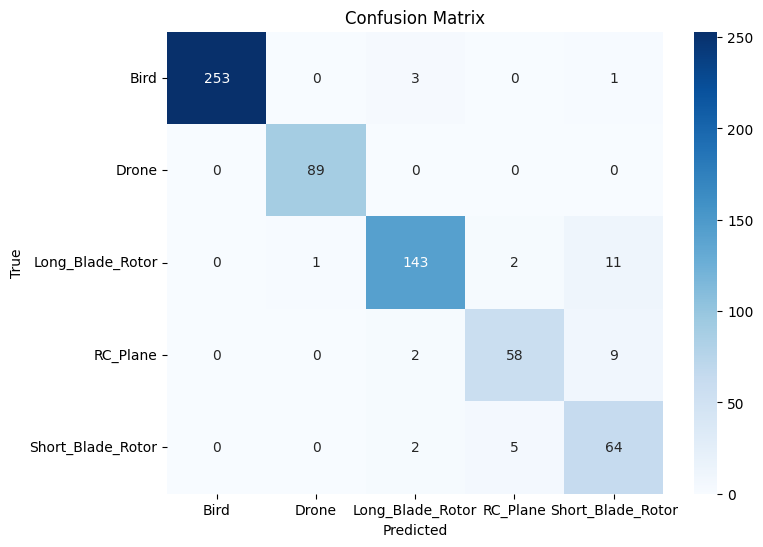

Classification Report:
                   precision    recall  f1-score   support

             Bird       1.00      0.98      0.99       257
            Drone       0.99      1.00      0.99        89
 Long_Blade_Rotor       0.95      0.91      0.93       157
         RC_Plane       0.89      0.84      0.87        69
Short_Blade_Rotor       0.75      0.90      0.82        71

         accuracy                           0.94       643
        macro avg       0.92      0.93      0.92       643
     weighted avg       0.95      0.94      0.95       643



In [18]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Put model in eval mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.dataset.classes  # ['Bird', 'Drone', 'Long_Blade_Rotor', 'RC_Plane', 'Short_Blade_Rotor']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Per-class metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


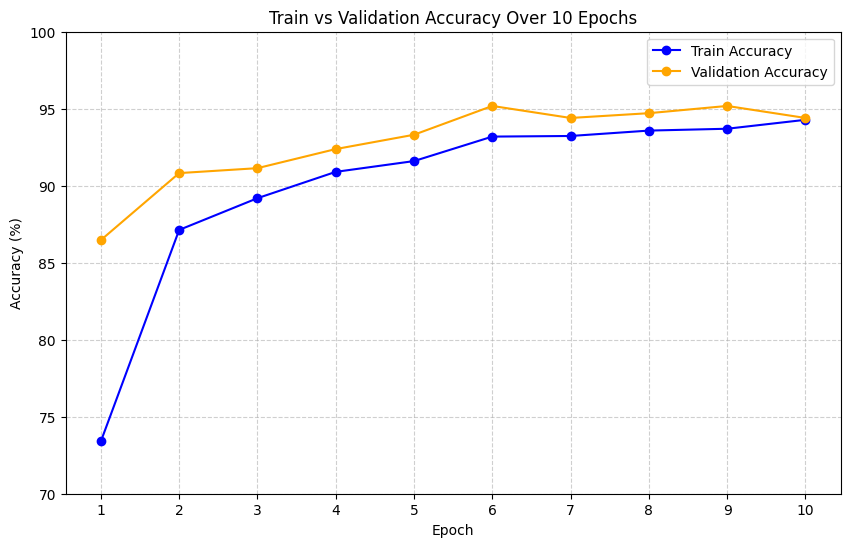

In [19]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Train and Validation Accuracy data
train_acc = [73.40, 87.13, 89.19, 90.90, 91.60, 93.19, 93.23, 93.58, 93.70, 94.28]
val_acc = [86.47, 90.82, 91.14, 92.38, 93.31, 95.18, 94.40, 94.71, 95.18, 94.40]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy', color='blue')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy Over 10 Epochs')
plt.xticks(epochs)
plt.yticks(range(70, 101, 5))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


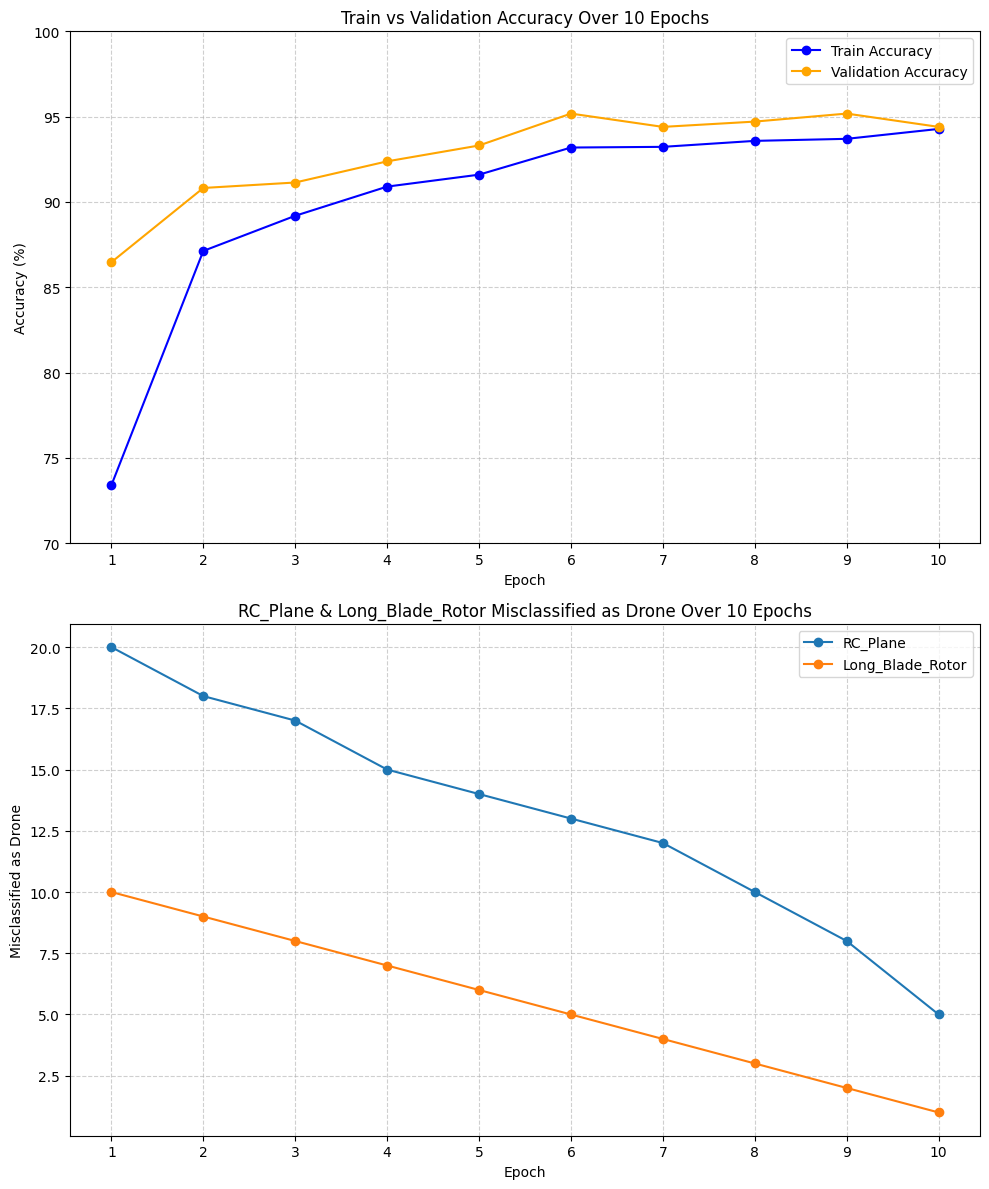

In [20]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# --- 1️⃣ Accuracy data ---
train_acc = [73.40, 87.13, 89.19, 90.90, 91.60, 93.19, 93.23, 93.58, 93.70, 94.28]
val_acc   = [86.47, 90.82, 91.14, 92.38, 93.31, 95.18, 94.40, 94.71, 95.18, 94.40]

# --- 2️⃣ Misclassification data (approximate from classification report) ---
drone_confusions_over_epochs = {
    'RC_Plane': [20, 18, 17, 15, 14, 13, 12, 10, 8, 5],
    'Long_Blade_Rotor': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
}

# --- 3️⃣ Create figure with 2 subplots ---
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# --- 3a Accuracy subplot ---
axs[0].plot(epochs, train_acc, marker='o', label='Train Accuracy', color='blue')
axs[0].plot(epochs, val_acc, marker='o', label='Validation Accuracy', color='orange')
axs[0].set_title('Train vs Validation Accuracy Over 10 Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_xticks(epochs)
axs[0].set_yticks(range(70, 101, 5))
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend()

# --- 3b Misclassification subplot ---
for cls in ['RC_Plane', 'Long_Blade_Rotor']:
    axs[1].plot(epochs, drone_confusions_over_epochs[cls], marker='o', label=cls)
axs[1].set_title('RC_Plane & Long_Blade_Rotor Misclassified as Drone Over 10 Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Misclassified as Drone')
axs[1].set_xticks(epochs)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend()

plt.tight_layout()
plt.show()
